In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

import warnings; warnings.simplefilter('ignore')
from time import time
import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from keras.optimizers import SGD, Adam, Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.layers import Dropout, Input, Dense,Lambda, BatchNormalization
from sklearn.utils import shuffle
from keras.models import Model,Sequential, load_model
from keras import backend as K
from keras.layers import Embedding, LSTM, concatenate
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

1 Physical GPUs, 1 Logical GPUs


Using TensorFlow backend.


In [2]:
####### Metricas ##########
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true, y_pred):
    return K.exp(K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)))

def coeff_determination_simple(y_true, y_pred):
    SS_res =  np.sum(np.square( y_true - y_pred )) 
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

###################### New MEthods ##########
def load_csv_data(url, drop_columns=[]):
    
    #READ data
    print("Loading data")
    df = pd.read_csv(url)
    print("Removing columns",drop_columns)
    df = df.drop(columns=drop_columns)
    return df

def log_targets(y_train, y_val, y_test):
    """ Transform to log scale """
    y_train_log = np.log(y_train)
    y_val_log = np.log(y_val)
    y_test_log = np.log(y_test)

    y_train_log_min = np.min(y_train_log)
    y_train_min = np.min(y_train)

    y_train_log_max = np.max(y_train_log)
    y_train_max = np.max(y_train)

    print("targets min:{} max: {}".format(y_train_min, y_train_max))
    print("targets in log scale min:{} max: {}".format(y_train_log_min, y_train_log_max))
    return y_train_log, y_val_log, y_test_log

def normalize_target(y_train_log, y_val_log, y_test_log):
    """
    Normalize data using StandardScaler.
    
    return scaler object; values of train,val and test sets standarized. 
    """
    #Standarización del target
    scaler = StandardScaler()
    y_train_log_std = scaler.fit_transform(y_train_log)
    y_val_log_std = scaler.transform(y_val_log)
    y_test_log_std = scaler.transform(y_test_log)
    return scaler, y_train_log_std, y_val_log_std, y_test_log_std

def get_metrics(model, scaler, x_data, y_true_data, label_set="Data"):
    y_pred = np.exp(scaler.inverse_transform(model.predict(x_data).reshape(-1, 1)))
    rmse = np.sqrt(mean_squared_error(y_true_data, y_pred))
    r2 = r2_score(y_true_data, y_pred)
    print("RMSE "+label_set, rmse)
    print("R2 SCORE "+label_set, r2)
    return rmse, r2

def plot_history(history, metrics_list, start_at_epoch=0):
    for metric in metrics_list:
        plt.plot(history.history[metric][start_at_epoch:],label=metric)
    plt.legend()
    plt.title("Metrics by epochs(Start from epoch:{})".format(start_at_epoch))
    plt.show()


In [3]:
#load new data
data_rnn =  pd.read_csv("models_newdata/datasetlsq_output_recurrentfeat.csv", delimiter="ᶶ")
data_rnn = data_rnn.drop(columns="Unnamed: 3")

#Data from files
data_algebra = pd.read_csv("/home/dcasals/graph-edit-distance/data/algebra_features.txt")
data_medoids = pd.read_csv("/home/dcasals/graph-edit-distance/data/vectors_medoids.csv")
result = data_algebra.merge(data_medoids, left_on='query_id', right_on='id')
result.head()
result = result.drop(columns=["query_id","Unnamed: 27_x", "Unnamed: 27_y"])
result.columns

nunique = result.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
print("Remove columns with same values: {}".format(cols_to_drop))
result = result.drop(cols_to_drop, axis=1)
new_cols = list(result.columns[:-25]) + ['pcs'+str(i) for i in list(range(0,25))]
result.columns = new_cols
result.columns

Remove columns with same values: Index(['path*', 'pathN*', 'path+', 'pathN+', 'notoneof', 'tolist', 'multi',
       'top', 'assign', 'sequence'],
      dtype='object')


Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'id', 'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3',
       'pcs4', 'pcs5', 'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11',
       'pcs12', 'pcs13', 'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19',
       'pcs20', 'pcs21', 'pcs22', 'pcs23', 'pcs24'],
      dtype='object')

In [4]:
result

,triple,bgp,join,leftjoin,union,filter,graph,extend,minus,order,...,pcs15,pcs16,pcs17,pcs18,pcs19,pcs20,pcs21,pcs22,pcs23,pcs24
0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.400000,0.166667,0.333333,0.500000,0.400000,0.285714,0.200000,0.333333,0.200000,0.200000
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
3,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.200000,0.333333,0.333333,0.285714,0.400000,0.200000,0.333333,0.200000,0.200000
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.142857,0.250000,0.400000,0.666667,0.250000,0.181818,0.250000,0.166667,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19108,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.666667,0.142857,0.250000,0.400000,0.666667,0.222222,0.166667,0.250000,0.166667,0.166667
19109,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
19110,6.0,6.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.153846,0.333333,0.333333,0.166667,0.153846,0.250000,0.200000,0.333333,1.000000,1.000000
19111,6.0,6.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.153846,0.333333,0.333333,0.166667,0.153846,0.250000,0.200000,0.333333,1.000000,1.000000


In [5]:
result = result[['id','triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'time','pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]

In [6]:
data_rnn = data_rnn.merge(result, left_on='id', right_on='id')
data_rnn

,id,tpfs,execTime,triple,bgp,join,leftjoin,union,filter,project,...,pcs15,pcs16,pcs17,pcs18,pcs19,pcs20,pcs21,pcs22,pcs23,pcs24
0,http://lsq.aksw.org/res/DBpedia-q113812,"2,http://www.w3.org/2000/01/rdf-schema#label,1...",4,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.400000,0.166667,0.333333,0.500000,0.400000,0.285714,0.200000,0.333333,0.200000,0.200000
1,http://lsq.aksw.org/res/DBpedia-q113813,"9,http://dbpedia.org/property/pushpinMap,",2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.666667,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
2,http://lsq.aksw.org/res/DBpedia-q113814,"9,http://dbpedia.org/property/reference,",2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.666667,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
3,http://lsq.aksw.org/res/DBpedia-q113815,"9,http://www.w3.org/2000/01/rdf-schema#label,9...",4,3.0,2.0,0.0,1.0,0.0,0.0,1.0,...,0.333333,0.200000,0.333333,0.333333,0.285714,0.400000,0.200000,0.333333,0.200000,0.200000
4,http://lsq.aksw.org/res/DBpedia-q113817,"9,http://www.w3.org/1999/02/22-rdf-syntax-ns#t...",2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.666667,0.142857,0.250000,0.400000,0.666667,0.250000,0.181818,0.250000,0.166667,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16956,http://lsq.aksw.org/res/DBpedia-q1014063,"1,http://www.w3.org/2000/01/rdf-schema#label,",55527,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.666667,0.142857,0.250000,0.400000,0.666667,0.222222,0.166667,0.250000,0.166667,0.166667
16957,http://lsq.aksw.org/res/DBpedia-q1085454,"1,http://dbpedia.org/property/label,",16592,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.666667,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
16958,http://lsq.aksw.org/res/LGD-q5773,"4,http://www.w3.org/1999/02/22-rdf-syntax-ns#t...",3434,6.0,6.0,0.0,3.0,2.0,0.0,1.0,...,0.153846,0.333333,0.333333,0.166667,0.153846,0.250000,0.200000,0.333333,1.000000,1.000000
16959,http://lsq.aksw.org/res/LGD-q5960,"4,http://www.w3.org/1999/02/22-rdf-syntax-ns#t...",3140,6.0,6.0,0.0,3.0,2.0,0.0,1.0,...,0.153846,0.333333,0.333333,0.166667,0.153846,0.250000,0.200000,0.333333,1.000000,1.000000


In [7]:
data_rnn.columns

Index(['id', 'tpfs', 'execTime', 'triple', 'bgp', 'join', 'leftjoin', 'union',
       'filter', 'project', 'distinct', 'treesize', 'time', 'pcs0', 'pcs1',
       'pcs2', 'pcs3', 'pcs4', 'pcs5', 'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10',
       'pcs11', 'pcs12', 'pcs13', 'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18',
       'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23', 'pcs24'],
      dtype='object')

In [18]:
from keras.utils import to_categorical
def procesar_tpfs_odd(x):
    """Get odd elements from a list """
    lista = []
    for a in x.split(",")[::2]:
        if a != "":
            if a.isdigit():
                lista.append(int(a))
            else:
                lista.append(0)
#     print(lista)
    return lista
def procesar_tpfs_even(x):
    """Get even elements from a list """
    lista  = [a for a in x.split(",")[1::2] if a != ""]
#     print(lista)
    return lista
def uri_2_index_seq(x,uri2Index):
    """transform uris to sequences"""
    lista  = [uri2Index[a] for a in x]
#     print(lista)
    return lista
def get_embedding_matrix_zero(index_dict, EMBEDDING_DIM):
    '''
        Generamos la matriz de embeddings, de dimensiones: 
          - (Tamano_vocabulario + 1) x Dimesion_embedding DecodeInput
    '''
    embedding_matrix = np.zeros((len(index_dict) + 1, EMBEDDING_DIM))
    return embedding_matrix

In [27]:

def build_RNN(num_pred_words, embedd_dim, embedd_type_dim, embedd_input_matrix,embedding_types_matrix, lstm_units, lstm_types_units):
    dropout = 0.25
    lstm_pred_input = Input(shape=(None,),name='lstm_pred_input')
    lstm_pred_embedd = Embedding(num_pred_words + 1 ,embedd_dim, weights=[embedd_input_matrix], trainable=True)(lstm_pred_input)
    lstm_pred_out = LSTM(lstm_units, name='lstm_pred_out')(lstm_pred_embedd)

    # Salida Auxiliar del modelo recurrente de predicados
#     aux_recurrent_pred_output = Dense(1, activation='linear', name='aux_recurrent_pred_output')(lstm_pred_out)
    
    lstm_type_input = Input(shape=(None,),name='lstm_type_input')
    lstm_type_embedd = Embedding(10 , embedd_type_dim, weights=[embedding_types_matrix], trainable=True)(lstm_type_input)
    lstm_type_out = LSTM(lstm_units, name='lstm_type_out')(lstm_type_embedd)

#     Salida Auxiliar del modelo recurrente de predicados
#     aux_recurrent_type_output = Dense(1, activation='linear', name='aux_recurrent_type_output')(lstm_type_out)
    
    dense_input = Input(shape=(34,), name='dense_input')    

    # We stack a deep densely-connected network on top
    x = Dense(260, activation='relu')(dense_input)
    x = Dropout(dropout)(x)
    x = Dense(300, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(240, activation='relu')(x)
#     x = concatenate([lstm_type_out,lstm_pred_out, x])
    x = concatenate([lstm_type_out, x])

    # And finally we add the main logistic regression layer
    main_output = Dense(1, activation='linear', name='main_output')(x)
    
    #Build model
#     model = Model(inputs=[lstm_type_input, lstm_pred_input, dense_input,], outputs=[main_output])
    model = Model(inputs=[lstm_type_input, dense_input,], outputs=[main_output])
    from keras.utils import plot_model
    plot_model(model, to_file='model.png')
    return model

def build_RNN2(num_pred_words, embedd_dim, embedd_type_dim, embedd_input_matrix,embedding_types_matrix, lstm_units, lstm_types_units):
    dropout = 0.25
    lstm_pred_input = Input(shape=(None,),name='lstm_pred_input')
    lstm_pred_embedd = Embedding(num_pred_words + 1 ,embedd_dim, weights=[embedd_input_matrix], trainable=True)(lstm_pred_input)
    lstm_pred_out = LSTM(lstm_units, name='lstm_pred_out')(lstm_pred_embedd)

    # Salida Auxiliar del modelo recurrente de predicados
#     aux_recurrent_pred_output = Dense(1, activation='linear', name='aux_recurrent_pred_output')(lstm_pred_out)
    
    lstm_type_input = Input(shape=(None,),name='lstm_type_input')
    lstm_type_embedd = Embedding(10 , embedd_type_dim, weights=[embedding_types_matrix], trainable=True)(lstm_type_input)
    lstm_type_out = LSTM(lstm_units, name='lstm_type_out')(lstm_type_embedd)

#     Salida Auxiliar del modelo recurrente de predicados
#     aux_recurrent_type_output = Dense(1, activation='linear', name='aux_recurrent_type_output')(lstm_type_out)
    
    dense_input = Input(shape=(34,), name='dense_input')    

    # We stack a deep densely-connected network on top
    x = Dense(260, activation='relu')(dense_input)
    x = Dropout(dropout)(x)
    x = Dense(300, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(240, activation='relu')(x)
    x = concatenate([lstm_type_out, lstm_pred_out])

    # And finally we add the main logistic regression layer
    main_output = Dense(1, activation='linear', name='main_output')(x)
    
    #Build model
    model = Model(inputs=[lstm_type_input, lstm_pred_input,], outputs=[main_output])
#     model = Model(inputs=[lstm_type_input, dense_input,], outputs=[main_output])
    return model

def build_ANN2():
    dropout = 0.25

    model = Sequential()
    model.add(Dense(260, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(300, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(240, activation='relu'))
    model.add(Dense(1, activation='linear'))
#     model = Model(inputs=[lstm_type_input, dense_input,], outputs=[main_output])
    return model

In [20]:
def separar_data(data_rnn):
    tpfs_structure = data_rnn['tpfs'].apply(lambda x: procesar_tpfs_odd(x))
    tpfs_predicate = data_rnn['tpfs'].apply(lambda x: procesar_tpfs_even(x))
    
    dense_data = data_rnn[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize','pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
    targets = data_rnn[['time']]
    print(dense_data.columns)
    return dense_data.values, tpfs_structure, tpfs_predicate, targets.values

def preprocesar_lstm_data(lstm_pred_data, lstm_type_data, EMBEDDING_DIM_PRED = 200, EMBEDDING_DIM_TYPES=10):
    #create indexes
    index = 1
    uri2Index = {}
    index2Uri = {}

    for lista in  lstm_pred_data.values:
        for val in lista:
            if val not in uri2Index:
                uri2Index[val] = index
                index2Uri[index] = val
                index +=1
    tpfs_pred_index = lstm_pred_data.apply(lambda x: uri_2_index_seq(x, uri2Index))
    
    #Max Len
    max_length = np.max(tpfs_pred_index.apply(lambda x: len(x)))
    paded_tpf_pred_data = np.array(pad_sequences(tpfs_pred_index.values.tolist(), maxlen=15, padding='post'))
    paded_tpf_types_data = np.array(pad_sequences(lstm_type_data.values.tolist(), maxlen=15, padding='post'))
    
    #Embedding Matrix
    
    emb_matrix_pred = get_embedding_matrix_zero(uri2Index, EMBEDDING_DIM_PRED)
    emb_matrix_types = np.zeros((9 + 1, EMBEDDING_DIM_TYPES))
    num_pred_words = len(uri2Index)
    
    return paded_tpf_pred_data, paded_tpf_types_data, num_pred_words, emb_matrix_pred, emb_matrix_types, uri2Index, index2Uri

def split_by_index(data, train_indexes, val_indexes, test_indexes):
    x_train      = data[train_indexes]
    x_val = data[val_indexes]
    x_test = data[test_indexes]
    return x_train, x_val, x_test
    
# lstm_type],scalery, y_train_log_std, y_val_log_std, y_test_log_std

In [21]:
dense_data, lstm_type_data, lstm_pred_data,  targets = separar_data(data_rnn)
EMBEDDING_DIM_PRED = 100
EMBEDDING_DIM_TYPES = 10
pad_pred_data, pad_types_data, num_pred_words, emb_matrix_pred, emb_matrix_types, uri2Index, index2Uri = preprocesar_lstm_data(lstm_pred_data, lstm_type_data, EMBEDDING_DIM_PRED, EMBEDDING_DIM_TYPES)

#We split the train indexes, and val indexes to half for get test_data
all_indexes = list(range(dense_data.shape[0]))
train_indexes, temp_indexes = train_test_split(all_indexes, test_size=0.3)
test_indexes, val_indexes = train_test_split(temp_indexes, test_size=0.5)

x_train, x_val, x_test = split_by_index(dense_data, train_indexes, val_indexes, test_indexes)
y_train, y_val, y_test = split_by_index(targets, train_indexes, val_indexes, test_indexes)

x_train_lstm_pred, x_val_lstm_pred, x_test_lstm_pred  = split_by_index(pad_pred_data, train_indexes, val_indexes, test_indexes)
x_train_lstm_type, x_val_lstm_type, x_test_lstm_type = split_by_index(pad_types_data, train_indexes, val_indexes, test_indexes)

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24'],
      dtype='object')


In [22]:
#Log and Normalize
y_train_log, y_val_log, y_test_log = log_targets(y_train, y_val, y_test)
scalery, y_train_log_std, y_val_log_std, y_test_log_std = normalize_target(y_train_log, y_val_log, y_test_log)

print("Shapes Train", x_train.shape,x_train_lstm_pred.shape, x_train_lstm_type.shape)
print("Shapes VAL", x_val.shape, x_val_lstm_pred.shape, x_val_lstm_type.shape)
print("Shapes TEST", x_test.shape, x_test_lstm_pred.shape, x_test_lstm_type.shape)

targets min:1 max: 118554
targets in log scale min:0.0 max: 11.683123831961872
Shapes Train (11872, 34) (11872, 15) (11872, 15)
Shapes VAL (2545, 34) (2545, 15) (2545, 15)
Shapes TEST (2544, 34) (2544, 15) (2544, 15)


In [23]:
def train_rnn_ann(model, x_train, y_train, x_val, y_val,optimizer=None):
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=20),
                          ModelCheckpoint(filepath='models_newdata/bestm_mixed.hdf5',
                                          monitor='val_loss', save_best_only=True
                                         )]
    if optimizer is None:
        optimizer=Adam(learning_rate=0.00015)
    model.compile(loss='mse', optimizer=optimizer, metrics=[coeff_determination, rmse])
    t0=time()
    epochs = 550
    print("before train: Init time: {}".format(round(t0,3)))
    history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=120,
                    validation_data=( x_val, y_val),
                    callbacks=callbacks_best,
                    verbose=True
                     )
    return model, history

In [27]:
EMBEDDING_DIM_PRED = 100
EMBEDDING_DIM_TYPES = 10

In [ ]:
model  = build_RNN(
    num_pred_words,
    EMBEDDING_DIM_PRED,
    EMBEDDING_DIM_TYPES,
    emb_matrix_pred,
    emb_matrix_types,
    lstm_units=32,
    lstm_types_units=5
    )
model,history = train_rnn_ann(model, x_train_lstm_type, x_train_lstm_pred, x_train, y_train_log_std,x_val_lstm_type, x_val_lstm_pred, x_val, y_val_log_std)

In [ ]:
model  = build_RNN2(
    num_pred_words,
    EMBEDDING_DIM_PRED,
    EMBEDDING_DIM_TYPES,
    emb_matrix_pred,
    emb_matrix_types,
    lstm_units=32,
    lstm_types_units=5
    )
from keras.utils import plot_model
plot_model(model, to_file='model.png')
model,history = train_rnn_ann(model, [x_train_lstm_type, x_train_lstm_pred], y_train_log_std,[x_val_lstm_type, x_val_lstm_pred], y_val_log_std)


In [ ]:
model  = build_ANN2(
        num_pred_words,
        EMBEDDING_DIM_PRED,
        EMBEDDING_DIM_TYPES,
        emb_matrix_pred,
        emb_matrix_types,
        lstm_units=32,
        lstm_types_units=5
    )
from keras.utils import plot_model
plot_model(model, to_file='model.png')
model,history = train_rnn_ann(model, [x_train], y_train_log_std,[x_val], y_val_log_std)


In [30]:
def build_train_ann(x_train, y_train, x_val, y_val, n1, n2, n3, epochs, optimizer, dropout, verbose=False):
    
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=20),
                      ModelCheckpoint(filepath='models_newdata/bestm_newdata.h5'.format(n1,n2,n3),
                                      monitor='val_loss', save_best_only=True
                                     )]

    model = Sequential()
    model.add(Dense(n1, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n3, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', coeff_determination, rmse])
    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))
    history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=120,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_best,
                    verbose=verbose
                     )
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0, 3)))
    print(model.summary())

    return model, history, round(t1-t0, 3)


In [31]:
optimizer=Adam(learning_rate=0.00015)
model, history, time_training = build_train_ann(
            x_train,
            y_train_log_std,
            x_val,
            y_val_log_std,
            260,
            300,
            240,
            500,
            optimizer,
            0.25,
            verbose=True)

before train: Init time: 1585600073.04
Train on 11872 samples, validate on 2545 samples
Epoch 1/500
11872/11872 [==============================] - 1s 104us/step - loss: 0.6868 - mae: 0.7209 - coeff_determination: 0.3069 - rmse: 2.2562 - val_loss: 0.5140 - val_mae: 0.5426 - val_coeff_determination: 0.5015 - val_rmse: 1.9814
Epoch 2/500
11872/11872 [==============================] - 1s 74us/step - loss: 0.4924 - mae: 0.5589 - coeff_determination: 0.5043 - rmse: 1.9547 - val_loss: 0.4109 - val_mae: 0.4281 - val_coeff_determination: 0.5997 - val_rmse: 1.8073
Epoch 3/500
11872/11872 [==============================] - 1s 74us/step - loss: 0.4137 - mae: 0.4806 - coeff_determination: 0.5843 - rmse: 1.8272 - val_loss: 0.3860 - val_mae: 0.3889 - val_coeff_determination: 0.6237 - val_rmse: 1.7685
Epoch 4/500
11872/11872 [==============================] - 1s 73us/step - loss: 0.3658 - mae: 0.4292 - coeff_determination: 0.6326 - rmse: 1.7457 - val_loss: 0.3649 - val_mae: 0.3629 - val_coeff_determin

RMSE Data 3221.6339280934617
R2 SCORE Data 0.009449106198590074
RMSE Val 3695.381437452946
R2 SCORE Val -0.02544755684684774
RMSE Test 2133.756315303828
R2 SCORE Test 0.02470239740147584


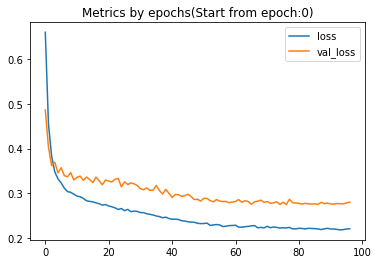

In [25]:
get_metrics(model, scalery, x_train, y_train, label_set="Data")
get_metrics(model, scalery, x_val, y_val, label_set="Val")
get_metrics(model, scalery, x_test, y_test, label_set="Test")
plot_history(history,['loss','val_loss',])